## FACIAL EXPRESSION RECOGNITION USING MobileNetV2

![MobileNetv2 Architecture](https://www.researchgate.net/publication/369624227/figure/fig8/AS:11431281131552328@1680145503560/The-architecture-of-the-MobileNetV2-with-a-sample-input-image-and-19-residual-bottleneck.png)

**IMPORTING NECESSARY LIBARIES**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
DATA=pd.read_csv("image_labels.csv")
DATA.head()

,Image,Label
0,1.jpg,Afraid
1,2.jpg,Afraid
2,3.jpg,Afraid
3,4.jpg,Afraid
4,5.jpg,Afraid


In [3]:
DATA.tail()

,Image,Label
4995,4996.jpg,Surprised
4996,4997.jpg,Surprised
4997,4998.jpg,Surprised
4998,4999.jpg,Surprised
4999,5000.jpg,Surprised


**LOADING AND PREPROCESSING DATA FUNCTION**

In [2]:
def LOAD_PREPROCESS_DATA(DATA_DIR):
    print("LOADING IMAGES IN PROCESS...")
    IMAGES, LABELS = [], []
    
    for EMOTION in os.listdir(DATA_DIR):
        EMOTION_PATH = os.path.join(DATA_DIR, EMOTION) 
    
        if os.path.isdir(EMOTION_PATH):  
            
            IMAGES_FILES = glob.glob(os.path.join(EMOTION_PATH, "*.*"))
    
            for IMG_PATH in IMAGES_FILES:
                
                IMG = cv2.imread(IMG_PATH)
                if IMG is not None:
                    IMG = cv2.resize(IMG, (224, 224)) 
                    IMAGES.append(IMG)
                    LABELS.append(EMOTION)
                    
    print("SUCCESSFULLY LOADED ALL IMAGES")
    
    IMAGES = np.array(IMAGES)
    LABELS = np.array(LABELS)
    
    return IMAGES,LABELS

#### **CALLING LOAD_PREPROCESS DATA FUNCTION**

In [ ]:
DATA_DIR = "FER_Dataset_5000"

IMAGES,LABELS=LOAD_PREPROCESS_DATA(DATA_DIR)

LOADING IMAGES IN PROCESS...
SUCCESSFULLY LOADED ALL IMAGES


#### **VERIFYING DATA**

In [4]:
print(f"NUMBER OF IMAGES LOADED WITH LABELS :{len(IMAGES)}")

print(f"SHAPE OF EACH IMAGE : {IMAGES[0].shape}")
UNIQUE_LABELS = np.unique(LABELS)

print(f"UNIQUE LABELS {len(UNIQUE_LABELS)}: ", UNIQUE_LABELS)

NUMBER OF IMAGES LOADED WITH LABELS :5000
SHAPE OF EACH IMAGE : (224, 224, 3)
UNIQUE LABELS 10:  ['Afraid' 'Angry' 'Contempt' 'Disgust' 'Eye_Rub' 'Hand_On_Chin' 'Happy'
 'Neutral' 'Sad' 'surprised']


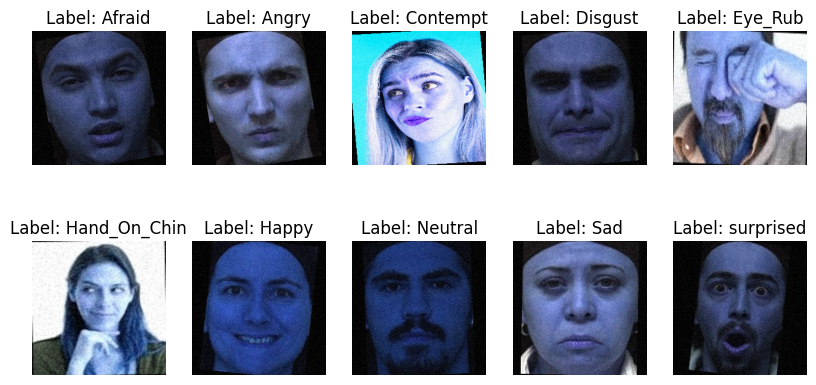

In [5]:
UNIQUE_LABELS, UNIQUE_INDICES = np.unique(LABELS, return_index=True)

UNIQUE_IMAGES = [IMAGES[i] for i in UNIQUE_INDICES]

ROWS, COLS = 2, 5

plt.figure(figsize=(10, 5))
for i, (img, label) in enumerate(zip(UNIQUE_IMAGES, UNIQUE_LABELS)):
    plt.subplot(ROWS, COLS, i + 1)
    plt.imshow(img, cmap='gray') 
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()


#### **APPLYING LABEL ENCODING**

In [6]:
print(f" LABEL BEFORE ENCODING : {UNIQUE_LABELS}")

LABEL_ENCODER = LabelEncoder()
Y_ENCODED = LABEL_ENCODER.fit_transform(LABELS)
Y_ONE_HOT = to_categorical(Y_ENCODED, num_classes=len(UNIQUE_LABELS))

print(f" LABEL AFTER ENCODING : {Y_ONE_HOT[0:5]}")

 LABEL BEFORE ENCODING : ['Afraid' 'Angry' 'Contempt' 'Disgust' 'Eye_Rub' 'Hand_On_Chin' 'Happy'
 'Neutral' 'Sad' 'surprised']
 LABEL AFTER ENCODING : [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


#### **SPLITING DATASET INTO TRAIN AND TEST**

In [7]:
X_TRAIN, X_VAL, Y_TRAIN, Y_VAL = train_test_split(IMAGES, Y_ONE_HOT, test_size=0.2, random_state=42)

#### **MODEL CONFIGURATION**

In [8]:
EPOCHS=30
LEARNING_RATE=0.0001
BATCH_SIZE=16
INPUT_SHAPE=(224, 224, 3)

#### **COVERTING DATA FROM NP ARRAY TO TENSORS FOR OPTIMIZED AND BETTER TRAINING PERFORMANCE**

In [9]:
TRAIN_DATASET = tf.data.Dataset.from_tensor_slices((X_TRAIN, Y_TRAIN)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
VAL_DATASET = tf.data.Dataset.from_tensor_slices((X_VAL, Y_VAL)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### **LOADING MODEL WITH PRETRAINED WEIGHTS**

In [10]:
BASE_MODEL = MobileNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)


x = BASE_MODEL.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(10, activation='softmax')(x) 

MODEL = Model(inputs=BASE_MODEL.input, outputs=out)

MODEL.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### **CHECKING MODEL DETAILS EG.LAYERS,NUMBER OF TRAINABLE PARAMETER ,NON TRAINABLE ETC**

In [11]:
MODEL.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,918,986 (11.14 MB)

 Trainable params: 2,884,874 (11.00 MB)

 Non-trainable params: 34,112 (133.25 KB)

#### **DEFINING FUNCTION FOR VISUALIZATION OF TRAINING ,VALIDATION LOSS & ACCURACY**

In [12]:
HISTORY = MODEL.fit(TRAIN_DATASET, validation_data=VAL_DATASET, epochs=EPOCHS)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 78ms/step - accuracy: 0.4159 - loss: 1.6254 - val_accuracy: 0.4220 - val_loss: 1.5280
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7978 - loss: 0.5163 - val_accuracy: 0.7290 - val_loss: 0.7652
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9514 - loss: 0.1514 - val_accuracy: 0.8370 - val_loss: 0.4997
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9851 - loss: 0.0528 - val_accuracy: 0.8760 - val_loss: 0.3665
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9948 - loss: 0.0250 - val_accuracy: 0.8870 - val_loss: 0.3968
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9976 - loss: 0.0137 - val_accuracy: 0.9000 - val_loss: 0.3487
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9841 - loss: 0.0375 - val_accuracy: 0.8450 - val_loss: 0.5840
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9795 - loss: 0.0618 - 

#### EVALUATING THE MODEL ACCURACY AND LOSS

In [13]:
VAL_LOSS, VAL_ACCURACY = MODEL.evaluate(VAL_DATASET)

print(f"Validation Loss: {VAL_LOSS:.4f}")
print(f"Validation Accuracy: {VAL_ACCURACY:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9913 - loss: 0.0368
Validation Loss: 0.0597
Validation Accuracy: 0.9850


#### DEFINING FUNCTION FOR VISUALIZATION OF TRAINING ,VALIDATION LOSS & ACCURACY

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report



def PLOT_TRAINING_CURVES(HISTORY):
    EPOCHS = range(1, len(HISTORY.history['accuracy']) + 1)
    plt.figure(figsize=(8, 10))
    
    # PLOT accuracy
    plt.subplot(2, 1, 1)
    plt.plot(EPOCHS, HISTORY.history['accuracy'], label='TRAINING ACCURACY', linestyle='-')
    plt.plot(EPOCHS, HISTORY.history['val_accuracy'], label='VALIDATION ACCURACY', linestyle='--')
    plt.xlabel('EPOCHS')
    plt.ylabel('ACCURACY')
    plt.legend()
    plt.title('TRAINING AND VALIDATION ACCURACY')
    plt.grid(True)
    
    # PLOT loss
    plt.subplot(2, 1, 2)
    plt.plot(EPOCHS, HISTORY.history['loss'], label='Training Loss', linestyle='-')
    plt.plot(EPOCHS, HISTORY.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.xlabel('EPOCHS')
    plt.ylabel('LOSS')
    plt.legend()
    plt.title('TRAINING AND VALIDATION LOSS')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

#### VISUALLY ANALYZING THE MODEL TRAINING ACCURACY AND LOSS

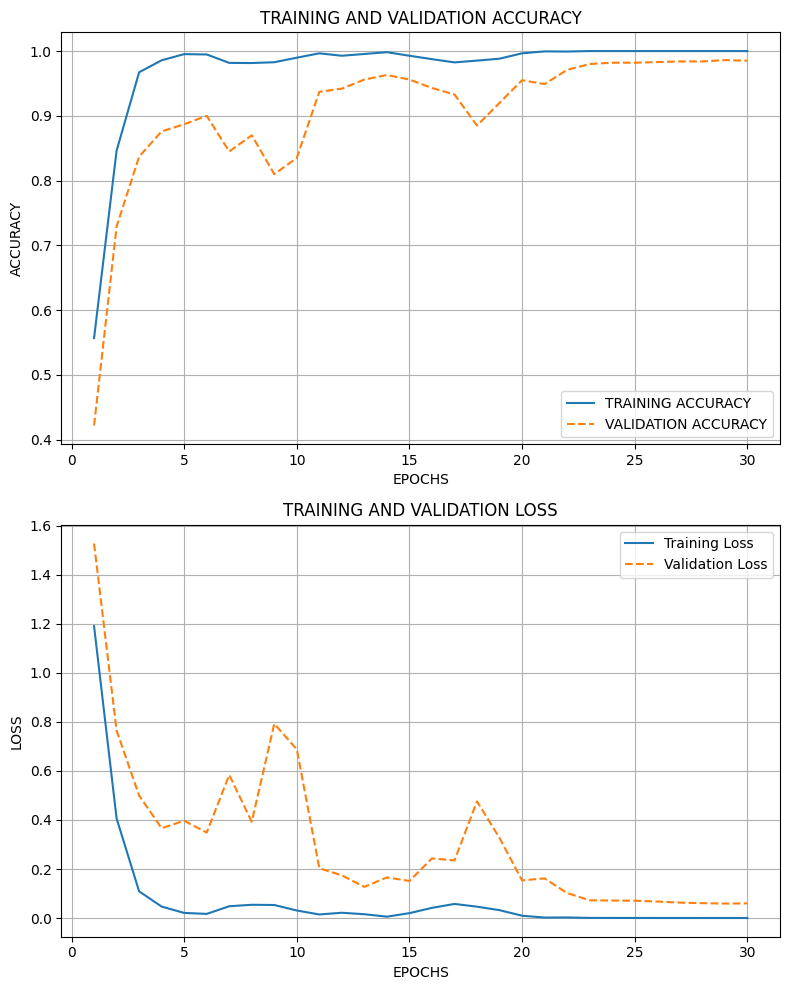

In [15]:

PLOT_TRAINING_CURVES(HISTORY)

#### FUNCTION FOR REPORT AND SCORE SUCH AS (ACCURACY,PRECISION ,RECALL,F1_SOCRE)

In [16]:
def EVALUATE_CLASSIFICATION_METRICS(MODEL, X_TEST, Y_TEST):
    
    Y_PRED = MODEL.predict(X_TEST)
    Y_PRED_CLASSES = Y_PRED.argmax(axis=1)
    Y_TRUE_CLASSES = Y_TEST.argmax(axis=1)
    
    accuracy = accuracy_score(Y_TRUE_CLASSES, Y_PRED_CLASSES)
    precision = precision_score(Y_TRUE_CLASSES, Y_PRED_CLASSES, average='weighted')
    recall = recall_score(Y_TRUE_CLASSES, Y_PRED_CLASSES, average='weighted')
    f1 = f1_score(Y_TRUE_CLASSES, Y_PRED_CLASSES, average='weighted')
    
    print(f'ACCURACY: {accuracy:.4f}')
    print(f'PRECISION: {precision:.4f}')
    print(f'RECALL: {recall:.4f}')
    print(f'F1 SCORE: {f1:.4f}')
    print('\nCLASSIFICATION REPORT:\n', classification_report(Y_TRUE_CLASSES, Y_PRED_CLASSES))

#### CALLING FUNCTION FOR GENERATING MODEL REPORT

In [17]:
EVALUATE_CLASSIFICATION_METRICS(MODEL, X_VAL, Y_VAL)

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step
ACCURACY: 0.9850
PRECISION: 0.9851
RECALL: 0.9850
F1 SCORE: 0.9850

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        98
           1       0.97      0.97      0.97       111
           2       1.00      1.00      1.00        81
           3       0.98      0.98      0.98       112
           4       1.00      1.00      1.00        98
           5       1.00      1.00      1.00        94
           6       0.98      1.00      0.99       111
           7       0.99      0.97      0.98       105
           8       0.99      0.98      0.99       105
           9       0.95      0.99      0.97        85

    accuracy                           0.98      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.98      0.98      1000



#### CONFUSION MATRIX FOR MODEL PERFORMANCE EVALUATION

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


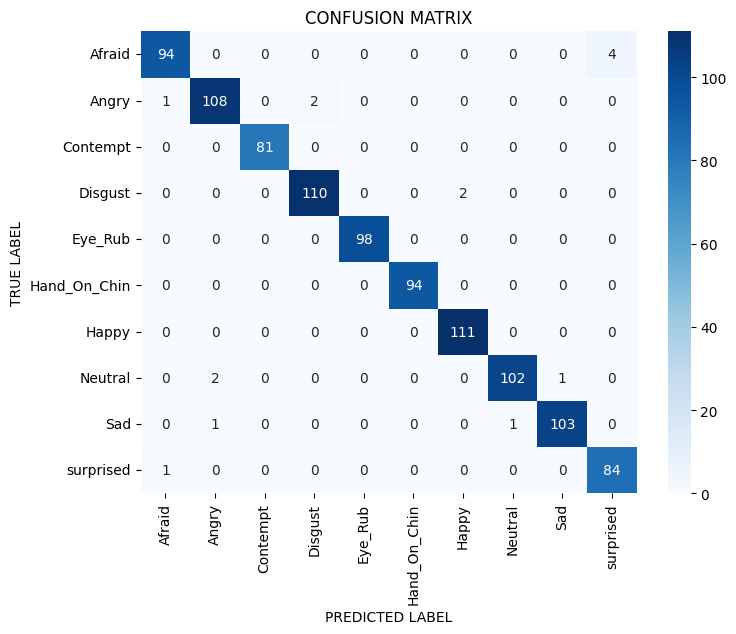

In [18]:
Y_TRUE_LIST = []
X_VAL_LIST = []

for x_batch, y_batch in VAL_DATASET:
    X_VAL_LIST.append(x_batch.numpy()) 
    Y_TRUE_LIST.append(y_batch.numpy())

X_VAL_FULL = np.concatenate(X_VAL_LIST, axis=0)
Y_TRUE = np.concatenate(Y_TRUE_LIST, axis=0)

Y_TRUE = np.argmax(Y_TRUE, axis=1)

Y_PRED_PROBS = MODEL.predict(X_VAL_FULL)

Y_PRED = np.argmax(Y_PRED_PROBS, axis=1)

CONFUSION_MATRIX = confusion_matrix(Y_TRUE, Y_PRED)

plt.figure(figsize=(8, 6))
sns.heatmap(CONFUSION_MATRIX, annot=True, fmt="d", cmap="Blues", 
            xticklabels=LABEL_ENCODER.classes_, 
            yticklabels=LABEL_ENCODER.classes_)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title("CONFUSION MATRIX")
plt.show()


In [ ]:
MODEL.save("facial_Expression_model_mobileNetv2.h5")